In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import seaborn as sns

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

df.corr()

,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
idno,1.000000,0.002102,0.003963,-0.007523,0.007397,0.004484,-0.003065,-0.021376,0.004323,0.010851,0.030051,-0.014931
year,0.002102,1.000000,-0.031596,-0.001600,0.004283,-0.032901,-0.013378,-0.028502,0.012150,0.001355,-0.003520,0.018689
tvtot,0.003963,-0.031596,1.000000,-0.142422,-0.119277,-0.069080,-0.118598,-0.078864,-0.092375,0.017922,0.257674,-0.028816
ppltrst,-0.007523,-0.001600,-0.142422,1.000000,0.597506,0.459250,0.231533,0.122555,0.137491,-0.029921,-0.029412,-0.034371
pplfair,0.007397,0.004283,-0.119277,0.597506,1.000000,0.480931,0.247755,0.096501,0.128808,0.022251,0.014724,-0.034054
pplhlp,0.004484,-0.032901,-0.069080,0.459250,0.480931,1.000000,0.215323,0.080489,0.092673,0.042046,0.040351,-0.022069
happy,-0.003065,-0.013378,-0.118598,0.231533,0.247755,0.215323,1.000000,0.182944,0.192030,-0.022413,-0.042970,-0.145061
sclmeet,-0.021376,-0.028502,-0.078864,0.122555,0.096501,0.080489,0.182944,1.000000,0.283319,0.009533,-0.194443,0.162970
sclact,0.004323,0.012150,-0.092375,0.137491,0.128808,0.092673,0.192030,0.283319,1.000000,-0.031648,-0.059442,0.011405
gndr,0.010851,0.001355,0.017922,-0.029921,0.022251,0.042046,-0.022413,0.009533,-0.031648,1.000000,0.020598,0.033984


(array([ 158.,    0.,  102.,    0.,  280.,    0.,  546.,    0.,  597.,
           0., 1522.,    0.,  993.,    0., 1755.,    0., 1557.,    0.,
         443.,  194.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <a list of 20 Patch objects>)

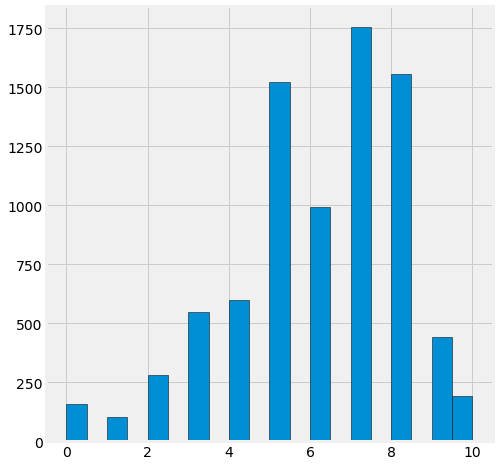

In [3]:
plt.figure(figsize=(8,8))
plt.style.use('fivethirtyeight')
plt.hist(df['pplfair'], bins = 20, edgecolor='k')

In [4]:
# Feature Engineering
# 1. Create Binary age classifier based median age
# 2. Transform Gender into binary
# 3. Create feature of level of not trust and not thinking people are fair
# 4. Create feature of unhappiness
# 5. Combine ppltrst, people fair and people help
df['gndr'] = df['gndr'] - 1
df['happy^2'] = df['happy']**2
df['tvno'] = max(df['tvtot']) - df['tvtot']
df['tvtot^2'] = df['tvtot']**2
df['sclmeet^2'] = df['sclmeet']
df['sclact^2'] = df['sclact']

In [5]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,happy^2,tvno,tvtot^2,sclmeet^2,sclact^2
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,1.0,60.0,1.0,64.0,4.0,9.0,5.0,4.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,1.0,59.0,1.0,81.0,1.0,36.0,3.0,2.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,0.0,24.0,2.0,49.0,6.0,1.0,6.0,3.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,1.0,64.0,1.0,100.0,3.0,16.0,6.0,2.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,1.0,55.0,1.0,64.0,2.0,25.0,7.0,2.0


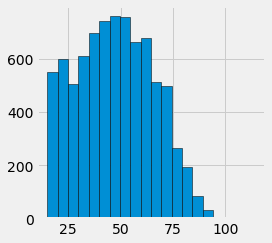

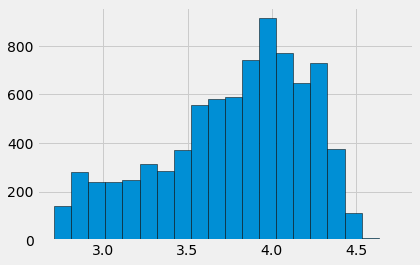

In [6]:
fig = plt.figure(figsize=(8,8))

fig.add_subplot(221)
plt.hist(df['agea'], bins=20, edgecolor='k')
plt.show()

fig.add_subplot(222)
plt.hist(np.log(df['agea']), bins=20, edgecolor='k')
plt.show()

In [7]:
# Normalize age by logging it
df['log_age'] = np.log(df['agea'])

In [8]:
# Combine ppltrust, pplfair and pplhlp variables
means = df[['ppltrst', 'pplfair', 'pplhlp']].mean(axis=0)
stds = df[['ppltrst', 'pplfair', 'pplhlp']].std(axis=0)
df['trust_fair_help'] = ((df[['ppltrst', 'pplfair', 'pplhlp']] - means)/stds).mean(axis=1)
df = df.drop(columns = ['ppltrst', 'pplfair', 'pplhlp'])

In [18]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)
X = X.drop(columns = ['year', 'agea', 'happy', 'sclact', 'sclmeet', 'tvno', 'tvtot', 'DE', 'SE'])

# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 80% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 20% in the test set.
X_test, y_test = X[offset:], y[offset:]


In [89]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))



Training set accuracy:
Percent Type I errors: 0.04357833358907473
Percent Type II errors: 0.16648764769065522

Test set accuracy:
Percent Type I errors: 0.05889570552147239
Percent Type II errors: 0.19202453987730062


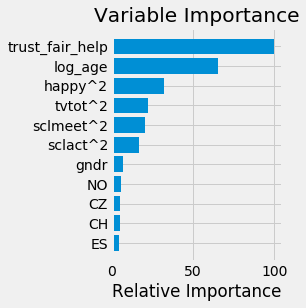

In [76]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Having trouble lowering error rates. If I lower type II errors, type I errors increase and vice versa. From trial and error I've figured that stronger features lower type I errors. And tuning hyper paramters like learning_rate and subsampling to reduce over fitting, reduces type II errors. Perhaps finding even better features will improve my model but I'm struggling to make those features.